## Learning Sparse Dynamical Models

We consider the case of learning the dynamics of a pendulum. In particular, we aim to learn the transition function $T:\mathcal{S}\times \mathcal{A}\rightarrow \mathcal{S}$, predicting the next state $\hat{\mathbf{s}}_{t+1}$ from the current state $\mathbf{s}_t$ and action $\mathbf{a}_t$: $$\hat{\mathbf{s}}_{t+1}=T(\mathbf{s}_t, \mathbf{a}_t).$$ We will approximate $T(\mathbf{s}_t, \mathbf{a}_t)$ using:
* a fully-connected neural network (fcnn_model),
* a fully-connected neural network sparsified by the L$_0$ regularization (sparsefcnn_model), and
* a SINDy-like architecture again sparsified by the L$_0$ regularization (l0sindy_model).

In [1]:
import gymnasium as gym
from utils.replay_buffer import ReplayBuffer
import torch
import numpy as np

# Set seeds
seed = 23524
torch.manual_seed(seed)
np.random.seed(seed)

We first create a training set composed of 1000 episodes of 200 steps each. The actions are sampled from a random policy.

In [ ]:
render = False
if render:
    env = gym.make('Pendulum-v1', g=9.81, render_mode="human")
else:
    env = gym.make('Pendulum-v1', g=9.81)
max_episodes = 1000
max_steps = 200

obs_dim = env.observation_space.shape[0]
act_dim = env.action_space.shape[0]
buf_dim = int(max_episodes*max_steps)

training_buffer = ReplayBuffer(obs_dim=obs_dim, act_dim=act_dim, size=buf_dim)

# create training set
for episode in range(max_episodes):
    observation, _ = env.reset()
    for steps in range(max_steps+1):
        action = env.action_space.sample()
        next_observation, reward, terminated, truncated, _ = env.step(action)

        done = terminated or truncated

        training_buffer.store(observation, action, reward, next_observation, done)

        env.render()

        observation = next_observation

        if done:
            done = False
            break

print("Finished creating the training set")

Secondly, we create the test set that we will use to evaluate the models.

In [3]:
# create test set
max_episodes_test = 100
buf_dim = int(max_episodes*max_steps)

testing_buffer = ReplayBuffer(obs_dim=obs_dim, act_dim=act_dim, size=buf_dim)

# create training set
for episode in range(max_episodes_test):
    observation, _ = env.reset()
    for steps in range(max_steps + 1):
        action = env.action_space.sample()
        next_observation, reward, terminated, truncated, _ = env.step(action)

        done = terminated or truncated

        testing_buffer.store(observation, action, reward, next_observation, done)

        env.render()

        observation = next_observation

        if done:
            done = False
            break

print("Finished creating the test set")

Finished creating the test set


After creating train and test set, we are now ready to train the three models. We utilize the same learning rate, batch size, and number of traning epochs.

In [4]:
from utils.models import FCNN, SparseFCNN, L0SINDy_dynamics
from utils.trainer import train_eval_dynamics_model
import torch

# number of hidden units used by the fcnn_model and the sparsefcnn_model
h_dim = 128

# shared hyperparameter of the experiment
lr = 3e-4
batch_size = 256
num_epochs = 500

Train and evaluate the fcnn_model.

In [ ]:
fcnn_model = FCNN(input_dim=obs_dim+act_dim, output_dim=obs_dim, h_dim=h_dim)

if torch.cuda.is_available():
    fcnn_model = fcnn_model.cuda()

optimizer_fcnn = torch.optim.Adam([
    {'params': fcnn_model.parameters()},
], lr=lr, weight_decay=0.0)

metrics_fcnn = train_eval_dynamics_model(fcnn_model, optimizer_fcnn, training_buffer, testing_buffer, batch_size, num_epochs)
print("Best testing error FCNN is {} and it was found at epoch {}".format(metrics_fcnn[2], metrics_fcnn[3]))

Train and evaluate the sparsefcnn_model.

In [6]:
reg_coefficient = 0.000005
sparsefcnn_model = SparseFCNN(input_dim=obs_dim+act_dim, output_dim=obs_dim, h_dim=h_dim, lambda_coeff=reg_coefficient)

if torch.cuda.is_available():
    sparsefcnn_model = sparsefcnn_model.cuda()

optimizer_sparsefcnn = torch.optim.Adam([
    {'params': sparsefcnn_model.parameters()},
], lr=lr, weight_decay=0.0)

metrics_sparsefcnn = train_eval_dynamics_model(sparsefcnn_model, optimizer_sparsefcnn, training_buffer, testing_buffer,
                                               batch_size, num_epochs, l0=True)
print("Best testing error sparse FCNN is {} and it was found at epoch {}".format(metrics_sparsefcnn[2], metrics_sparsefcnn[3]))

L0Dense(4 -> 128, droprate_init=0.5, lamba=5e-06, temperature=0.6666666666666666, weight_decay=0.0, local_rep=False)
L0Dense(128 -> 128, droprate_init=0.5, lamba=5e-06, temperature=0.6666666666666666, weight_decay=0.0, local_rep=False)
L0Dense(128 -> 3, droprate_init=0.5, lamba=5e-06, temperature=0.6666666666666666, weight_decay=0.0, local_rep=False)


/home/nicolo/Documents/Sparsifying-Parametric-Models-with-L0/utils/l0_layer.py:51: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  init.kaiming_normal(self.weights, mode='fan_out')


====> Epoch: 0 Average train loss: 1.9357626689
====> Epoch: 0 Average L0 reg loss: 0.0718839753
====> Epoch: 0 Average eval loss: 0.3897535205
====> Epoch: 1 Average train loss: 1.5835513903
====> Epoch: 1 Average L0 reg loss: 0.0718958646
====> Epoch: 1 Average eval loss: 0.3284494877
====> Epoch: 2 Average train loss: 1.5679122517
====> Epoch: 2 Average L0 reg loss: 0.0719184796
====> Epoch: 2 Average eval loss: 0.2783397436
====> Epoch: 3 Average train loss: 1.2588246811
====> Epoch: 3 Average L0 reg loss: 0.0719482836
====> Epoch: 3 Average eval loss: 0.2147325277
====> Epoch: 4 Average train loss: 1.2533747192
====> Epoch: 4 Average L0 reg loss: 0.0719848296
====> Epoch: 4 Average eval loss: 0.2362017483
====> Epoch: 5 Average train loss: 1.2129035863
====> Epoch: 5 Average L0 reg loss: 0.0720251836
====> Epoch: 5 Average eval loss: 0.2104419321
====> Epoch: 6 Average train loss: 1.1388231519
====> Epoch: 6 Average L0 reg loss: 0.0720646028
====> Epoch: 6 Average eval loss: 0.174

Train and evaluate the l0-sindy model with polynomial library functions.

In [ ]:
lib_type = 'polynomial'
# degree of the polynomial features
degree = 3

reg_coefficient = 0.00005

l0sindy_model = L0SINDy_dynamics(input_dim=obs_dim+act_dim, output_dim=obs_dim, degree=degree, lambda_coeff=reg_coefficient, lib_type=lib_type)

if torch.cuda.is_available():
    l0sindy_model = l0sindy_model.cuda()

optimizer_fcnn = torch.optim.Adam([
    {'params': l0sindy_model.parameters()},
], lr=lr, weight_decay=0.0)

metrics_poly_l0sindy = train_eval_dynamics_model(l0sindy_model, optimizer_fcnn, training_buffer, testing_buffer, batch_size, num_epochs, l0=True)
print("Best testing error polynomial L0 SINDy is {} and it was found at epoch {}".format(metrics_poly_l0sindy[2], metrics_poly_l0sindy[3]))

# print the close-form equation of the model. Great for interpretability!!!
l0sindy_model.print_equations()

Train and evaluate the l0-sindy model with Fourier library functions.

In [ ]:
lib_type = 'fourier'

frequency = 1

reg_coefficient = 0.005

l0sindy_model = L0SINDy_dynamics(input_dim=obs_dim+act_dim, output_dim=obs_dim, degree=degree, lambda_coeff=reg_coefficient, lib_type=lib_type)

if torch.cuda.is_available():
    l0sindy_model = l0sindy_model.cuda()

optimizer_fcnn = torch.optim.Adam([
    {'params': l0sindy_model.parameters()},
], lr=lr, weight_decay=0.0)

metrics_fourier_l0sindy = train_eval_dynamics_model(l0sindy_model, optimizer_fcnn, training_buffer, testing_buffer, batch_size, num_epochs, l0=True)
print("Best testing error Fourier L0 SINDy is {} and it was found at epoch {}".format(metrics_fourier_l0sindy[2], metrics_fourier_l0sindy[3]))

# print the close-form equation of the model. Great for interpretability!!!
l0sindy_model.print_equations()

Train and evaluate the l0-sindy model with polynomial and Fourier library functions.


In [ ]:
lib_type = 'polyfourier'

degree = 3
frequency = 1

reg_coefficient = 0.0005

l0sindy_model = L0SINDy_dynamics(input_dim=obs_dim+act_dim, output_dim=obs_dim, degree=degree, lambda_coeff=reg_coefficient, lib_type=lib_type)

if torch.cuda.is_available():
    l0sindy_model = l0sindy_model.cuda()

optimizer_fcnn = torch.optim.Adam([
    {'params': l0sindy_model.parameters()},
], lr=lr, weight_decay=0.0)

metrics_polyfourier_l0sindy = train_eval_dynamics_model(l0sindy_model, optimizer_fcnn, training_buffer, testing_buffer, batch_size, num_epochs, l0=True)
print("Best testing error polynomial+Fourier L0 SINDy is {} and it was found at epoch {}".format(metrics_polyfourier_l0sindy[2], metrics_polyfourier_l0sindy[3]))

# print the close-form equation of the model. Great for interpretability!!!
l0sindy_model.print_equations()

Eventually, we plot the mean-squared error between the predictions and the ground-truth over the training and test set.

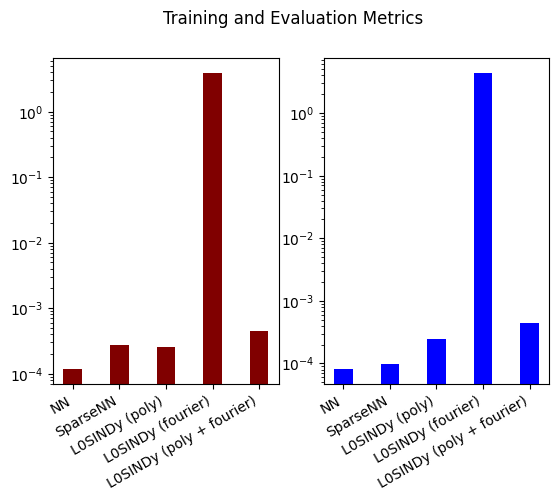

In [22]:
# creating the plots
import matplotlib.pyplot as plt
import os

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Training and Evaluation Metrics')

data_train = {'NN': metrics_fcnn[0], 'SparseNN': metrics_sparsefcnn[0], 'L0SINDy (poly)': metrics_poly_l0sindy[0], 'L0SINDy (fourier)': metrics_fourier_l0sindy[0], 'L0SINDy (poly + fourier)': metrics_polyfourier_l0sindy[0]}
methods_train = list(data_train.keys())
values_train = list(data_train.values())

# creating the bar plot
ax1.bar(methods_train, values_train, color='maroon', width=0.4)
ax1.set_yscale('log')

data_eval = {'NN': metrics_fcnn[2], 'SparseNN': metrics_sparsefcnn[2], 'L0SINDy (poly)': metrics_poly_l0sindy[2], 'L0SINDy (fourier)': metrics_fourier_l0sindy[2], 'L0SINDy (poly + fourier)': metrics_polyfourier_l0sindy[2]}
methods_eval = list(data_eval.keys())
values_eval = list(data_eval.values())

ax2.bar(methods_eval, values_eval, color='blue', width=0.4)
ax2.set_yscale('log')

fig.autofmt_xdate()

save_dir = "figures"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
fig.savefig('figures/LearningDynamics.png', dpi=300)